# Project Report EVA_CE4IB

| | |
| --- | --- |
| Author | David Kempf |
| Professor | Christian Ghiaus |
| Date | January 11, 2024 |

# Problem
In the following, the problem statement and a hypothesis are formulated and the model is presented.

This project focuses on a building located in St. Gallen which is in need of renovation regarding its envelope (improvement energy balance etc.). Since the renovation cannot be carried out from the outer side, an alternative approach has been brought forward by Beat Kegel which comprises putting up insulation planes from the inside on the cealings of rooms corresponding to the thermal bridges.

The hypothesis states that by choosing suitable dimensions and locations for the mentioned insulation plates inside the (exterior) rooms it is possible to achieve a similar insulation effect as if a new layer of insulation would be applied from the outside. After developing an appropriate model, the ultimate goal is to find dimensions and locations that confirm the hypothesis.

Figure 1 presents the simple scheme of a thermal zone (room) lied towards the outside of the building that will be used as the basis for the model to be employed.

![Scheme of thermal zone used as the basis for the model](./figures/building_plan_v42.png)
> Figure 1. A ventilated thermal zone enclosed by 5 walls and a sixth one containing a glass window.

In figure 2, the thermal network for this thermal zone is displayed. It considers solar radiation on the walls and glass window and ventilation.

![Thermal network of thermal zone](./figures/thermal_circuit_v42.png)
> Figure 2. The thermal network of the thermal zone considering solar radiation, ventilation and setpoint temperatures in adjacent thermal zones (rooms).

## Model

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl

import dm4bem

### Dimensions and surface areas of thermal zone

In [2]:
# Lengths of the walls - w_l
shorter_wall_edge_length = 2.5
longer_wall_edge_length = shorter_wall_edge_length

# This fraction assumes that the "shorter wall edge length" is really the
# shorter wall edge length. This supports the case of a rectangular shape
# of the thermal zone.
shorter_wall_edge_length_window_fraction = 0.3

# Lengths of the insulation plate(s) - i_l
shorter_insulation_plate_edge_length = 0.5
longer_insulation_plate_edge_length = shorter_insulation_plate_edge_length

# Surface areas of the walls, the glass window and the insulation plate(s)
wall_surface_area = ((4 * shorter_wall_edge_length * longer_wall_edge_length) + shorter_wall_edge_length**2 # S_w
                     + (shorter_wall_edge_length**2 * (1 - shorter_wall_edge_length_window_fraction)))
insulation_plate_surface_area = ((4 * shorter_insulation_plate_edge_length * longer_insulation_plate_edge_length) # S_i
                                 + 2 * shorter_insulation_plate_edge_length**2)
window_surface_area = shorter_wall_edge_length**2 * shorter_wall_edge_length_window_fraction 

print(f'Shorter wall edge length: {shorter_wall_edge_length}')
print(f'Longer wall edge length: {longer_wall_edge_length}')
print(f'Shorter wall edge length window fraction: {shorter_wall_edge_length_window_fraction}')
print()
print(f'Shorter insulation plate edge length: {shorter_insulation_plate_edge_length}')
print(f'Longer insulation plate edge length: {longer_insulation_plate_edge_length}')
print()
print(f'Wall surface area: {wall_surface_area}')
print(f'Insulation surface area: {insulation_plate_surface_area}')
print(f'Window surface area: {window_surface_area}')

Shorter wall edge length: 2.5
Longer wall edge length: 2.5
Shorter wall edge length window fraction: 0.3

Shorter insulation plate edge length: 0.5
Longer insulation plate edge length: 0.5

Wall surface area: 35.625
Insulation surface area: 1.5
Window surface area: 1.875


### Thermo-physical properties

In [3]:
# Thermo-physical properties in SI units
air_properties = {'Density': 1.2, # kg/m^3
                  'Specific heat': 1000} # J/(kg*K)

wall_properties = {'Conductivity': 1.400,
                   'Density': 2300.0, # kg/m3
                   'Specific heat': 880, # J/(kg*K)
                   'Width': 0.15, # m
                   'Surface': wall_surface_area} # m^2

insulation_plate_properties = {'Conductivity': 0.025,
                               'Density': 50.0,
                               'Specific heat': 1210,
                               'Width': 0.025,
                               'Surface': insulation_plate_surface_area}

window_properties = {'Conductivity': 1.4,
                     'Density': 2500,
                     'Specific heat': 1210,
                     'Width': 0.04,
                     'Surface': window_surface_area}

wall_properties = pd.DataFrame.from_dict({'Outside_layer': wall_properties,
                                          'Inside_layer': insulation_plate_properties,
                                          'Window': window_properties},
                                          orient='index')

print('Air properties:')
print()
print(pd.DataFrame(air_properties, index=['Air']))
print()
print('Wall properties:')
print()
print(wall_properties)

Air properties:

     Density  Specific heat
Air      1.2           1000

Wall properties:

               Conductivity  Density  Specific heat  Width  Surface
Outside_layer         1.400   2300.0            880  0.150   35.625
Inside_layer          0.025     50.0           1210  0.025    1.500
Window                1.400   2500.0           1210  0.040    1.875


### Radiative properties

In [4]:
long_wave_wall_emmisivity = 0.85 # ε_wLW
long_wave_window_emmisivity = 0.90 # ε_gLW
short_wave_white_smooth_surface_absortivity = 0.25 # α_wSW
short_wave_reflective_blue_window_absortivity = 0.38 # α_gSW
short_wave_reflective_blue_window_transmittance = 0.30 # τ_gSW

stephan_boltzmann_constant = 5.67e-8 # σ, W/(m²⋅K⁴)

print(f'Long wave wall emmisivity: {long_wave_wall_emmisivity}')
print(f'Long wave window emmisivityy: {long_wave_window_emmisivity}')
print(f'Short wave white smooth surface absortivity: {short_wave_white_smooth_surface_absortivity}')
print(f'Short wave reflective blue window absortivity: {short_wave_reflective_blue_window_absortivity}')
print(f'Short wave reflective blue window transmittance: {short_wave_reflective_blue_window_transmittance}')
print(f'Stephan-Boltzmann constant: {stephan_boltzmann_constant}')

Long wave wall emmisivity: 0.85
Long wave window emmisivityy: 0.9
Short wave white smooth surface absortivity: 0.25
Short wave reflective blue window absortivity: 0.38
Short wave reflective blue window transmittance: 0.3
Stephan-Boltzmann constant: 5.67e-08


### Convection coefficients

In [5]:
convection_coefficients = pd.DataFrame([{'In': 8., 'Out': 25}], index=['h']) # W/(m2*K), h

print(convection_coefficients)

    In  Out
h  8.0   25


### Thermal network

#### General variables

In [6]:
# Number of branches equals number of conductances.
number_of_branches = 36 # 25
number_of_nodes = 25 # 18

number_of_temperature_sources = 9 # 8
number_of_heat_flow_rate_sources = 5 # 0

print(f'Number of branches: {number_of_branches}')
print(f'Number of nodes: {number_of_nodes}')
print(f'Number of temperature sources: {number_of_temperature_sources}')
print(f'Number of heat flow rate sources: {number_of_heat_flow_rate_sources}')

#temperature_sources = np.zeros(number_of_temperature_sources)
#temperature_sources[0:4] = 15 # Slicing end index is exclusive.
#temperature_sources[4:8] = 24 # Slicing end index is exclusive.
#heat_flow_rate_sources[] = 

#temperature_sources

Number of branches: 36
Number of nodes: 25
Number of temperature sources: 9
Number of heat flow rate sources: 5


#### Thermal conductances

##### Conduction

In [7]:
conduction_conductances = wall_properties['Conductivity'] / wall_properties['Width'] * wall_properties['Surface'] # G_cd

print(pd.DataFrame(conduction_conductances, columns=['Conductance']))

               Conductance
Outside_layer      332.500
Inside_layer         1.500
Window              65.625


##### Convection

In [8]:
wall_convection_conductances = convection_coefficients * wall_properties['Surface'][0] # G_w
window_convection_conductances = convection_coefficients * wall_properties['Surface'][2] # G_g

print('Wall convection conductances:')
print()
print(wall_convection_conductances)
print()
print('Window convection conductances:')
print()
print(window_convection_conductances)

Wall convection conductances:

      In      Out
h  285.0  890.625

Window convection conductances:

     In     Out
h  15.0  46.875


##### Long wave radiation

###### View factors inside the building

In [9]:
wall_to_window_view_factor = window_properties['Surface'] / wall_properties['Surface']['Inside_layer'] # F_wg

print('Wall to window view factor:')
print()
print(wall_to_window_view_factor)

Wall to window view factor:

1.25


###### View factor between tilted outdoor walls and sky

###### Thermal network for long wave radiation

In [10]:
radiative_exchange_mean_temperature = 20 + 273 # K, T_m

radiation_conductance_1 = (4 * stephan_boltzmann_constant * radiative_exchange_mean_temperature**3 * long_wave_wall_emmisivity # G_LW1
                           / (1 - long_wave_wall_emmisivity) * wall_properties['Surface']['Inside_layer'])
radiation_conductance_12 = (4 * stephan_boltzmann_constant * radiative_exchange_mean_temperature**3 * wall_to_window_view_factor # G_LW12
                            * wall_properties['Surface']['Inside_layer'])
radiation_conductance_2 = (4 * stephan_boltzmann_constant * radiative_exchange_mean_temperature**3 * long_wave_window_emmisivity # G_LW2
                           / (1 - long_wave_window_emmisivity) * wall_properties['Surface']['Window'])

long_wave_radiation_wall_window = 1 / (1 / radiation_conductance_1 + 1 / radiation_conductance_12 + 1 / radiation_conductance_2) # G_LW

print(f'Radiative exchange mean temperature: {radiative_exchange_mean_temperature}')
print(f'Radiation conductance 1: {radiation_conductance_1}')
print()
print('Radiation conductance 12:')
print()
print(radiation_conductance_12)
print()
print(f'Radiation conductance 2: {radiation_conductance_2}')
print()
print('Long wave radiation wall window:')
print()
print(long_wave_radiation_wall_window)

Radiative exchange mean temperature: 293
Radiation conductance 1: 48.4914127446

Radiation conductance 12:

10.69663516425

Radiation conductance 2: 96.26971647825003

Long wave radiation wall window:

8.032319902479754


##### Advection

In [11]:
thermal_zonne_air_volume = shorter_wall_edge_length**2 * longer_wall_edge_length # m³, V_a
air_changes_per_hour = 1 # ACH
air_infiltration = air_changes_per_hour / 3600 * thermal_zonne_air_volume # m³/s, V_a-dot

advection_conductance =  air_properties['Density'] * air_properties['Specific heat'] * air_infiltration # G_v

print(f'Thermal zone air volume: {thermal_zonne_air_volume}')
print(f'Air changes per hour: {air_changes_per_hour}')
print(f'Air infiltration: {air_infiltration}')
print(f'Advection conductance: {advection_conductance}')

Thermal zone air volume: 15.625
Air changes per hour: 1
Air infiltration: 0.004340277777777778
Advection conductance: 5.208333333333334


##### Proportional controller

In [12]:
proportional_gain = 1e4 # W/K, K_p
proportional_gain = 1e-3
proportional_gain = 0
#proportional_gain = 1e4

print(f'Proportional gain: {proportional_gain}')

Proportional gain: 0


##### Conductances in series and/or parallel

In [13]:
outdoor_window_half_convection_conduction_conductance = float(1 / (1 / window_convection_conductances.loc['h', 'Out'] # G_gs
                                                                   + 1 / (2 * conduction_conductances['Window'])))

print(f'Outdoor window half convection conductance and conduction conductance: {outdoor_window_half_convection_conduction_conductance}')

Outdoor window half convection conductance and conduction conductance: 34.53947368421053


#### Thermal capacities
##### Walls

In [14]:
thermal_capacities = wall_properties['Density'] * wall_properties['Specific heat'] * wall_properties['Surface'] * wall_properties['Width'] # J/kg, C_w

print('Thermal capacities:')
print()
print(thermal_capacities)

Thermal capacities:

Outside_layer    10815750.00
Inside_layer         2268.75
Window             226875.00
dtype: float64


##### Air

In [15]:
thermal_capacities['Air'] = air_properties['Density'] * air_properties['Specific heat'] * thermal_zonne_air_volume # J/kg, C_a
pd.DataFrame(thermal_capacities, columns=['Capacity'])

print('Thermal capacities:')
print()
print(thermal_capacities)

Thermal capacities:

Outside_layer    10815750.00
Inside_layer         2268.75
Window             226875.00
Air                 18750.00
dtype: float64


#### Temperature sources

##### Outdoor air and ground temperature

##### Adjacent spaces with controlled temperature

##### Setpoint temperature

#### Heat flow rate sources

##### Solar radiation absorbed by the walls

###### External wall

###### Internal walls

##### Internal sources

### System of algebraic-differential equations (DAE)

#### A: incidence matrix

In [16]:
incidence_matrix = np.zeros([number_of_branches, number_of_nodes]) # number of branches times number of nodes, A

# "Slice 1"
incidence_matrix[0, 0] = 1 # Branch q_0 enters node theta_0.

incidence_matrix[1, 0] = -1 # Branch q_1 leaves node theta_0.
incidence_matrix[1, 1] = 1 # analogously
incidence_matrix[2, 1] = -1
incidence_matrix[2, 2] = 1

incidence_matrix[3, 2] = 1
incidence_matrix[3, 3] = -1

incidence_matrix[4, 3] = 1

incidence_matrix[5, 1] = -1
incidence_matrix[5, 5] = 1

# "Slice 2"

incidence_matrix[6, 4] = 1

incidence_matrix[7, 4] = -1
incidence_matrix[7, 5] = 1
incidence_matrix[8, 5] = -1
incidence_matrix[8, 6] = 1

incidence_matrix[9, 6] = 1
incidence_matrix[9, 7] = -1

incidence_matrix[10, 7] = 1

incidence_matrix[11, 5] = -1
incidence_matrix[11, 8] = 1

# "Slice 3"

incidence_matrix[12, 8] = -1
incidence_matrix[12, 9] = 1

incidence_matrix[13, 9] = -1
incidence_matrix[13, 10] = 1
incidence_matrix[14, 10] = -1
incidence_matrix[14, 11] = 1
incidence_matrix[15, 11] = -1
incidence_matrix[15, 12] = 1

incidence_matrix[16, 12] = 1
incidence_matrix[16, 13] = -1

incidence_matrix[17, 13] = 1

# "Slice 4"

incidence_matrix[18, 14] = 1

incidence_matrix[19, 14] = -1
incidence_matrix[19, 15] = 1
incidence_matrix[20, 15] = -1
incidence_matrix[20, 11] = 1
incidence_matrix[21, 11] = -1
incidence_matrix[21, 16] = 1
incidence_matrix[22, 16] = -1
incidence_matrix[22, 17] = 1
incidence_matrix[23, 17] = -1
incidence_matrix[23, 18] = 1

incidence_matrix[24, 18] = 1

incidence_matrix[25, 9] = -1
incidence_matrix[25, 19] = 1

# "Slice 5"

incidence_matrix[26, 19] = -1
incidence_matrix[26, 20] = 1

incidence_matrix[34, 20] = -1
incidence_matrix[34, 17] = 1
incidence_matrix[35, 17] = -1
incidence_matrix[34, 24] = 1
incidence_matrix[27, 20] = -1
incidence_matrix[27, 21] = 1

incidence_matrix[28, 21] = 1

# "Slice 6"

incidence_matrix[29, 22] = 1

incidence_matrix[30, 22] = -1
incidence_matrix[30, 23] = 1
incidence_matrix[31, 23] = -1
incidence_matrix[31, 24] = 1

incidence_matrix[32, 24] = -1

# "Slice 7"

incidence_matrix[33, 23] = -1
incidence_matrix[33, 12] = 1

print('Incidence matrix:')
print()
print(incidence_matrix)

Incidence matrix:

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0

#### G: conductance matrix

In [17]:
print(np.shape(long_wave_radiation_wall_window))

conductance_matrix = np.diag(np.hstack([wall_convection_conductances['Out'], # G # R0 - Convection at the inner wall of the adjacent zone.
                                        2 * conduction_conductances['Outside_layer'], # R1 - Conduction in the wall
                                        2 * conduction_conductances['Outside_layer'], # R2 - Conduction in the wall
                                        wall_convection_conductances['In'], # R3 - Convection at the inner wall of the thermal zone.
                                        advection_conductance, # # R4 - Advection from ventilation
                                        2 * conduction_conductances['Outside_layer'], # R5 - Conduction in the wall
                                        wall_convection_conductances['Out'], # R6 - Convection at the inner wall of the adjacent zone.
                                        2 * conduction_conductances['Outside_layer'], # R7
                                        2 * conduction_conductances['Outside_layer'], # R8
                                        wall_convection_conductances['In'], # R9
                                        advection_conductance, # R10
                                        2 * conduction_conductances['Outside_layer'], # R11
                                        2 * conduction_conductances['Outside_layer'], # R12
                                        2 * conduction_conductances['Outside_layer'], # R13 
                                        2 * conduction_conductances['Inside_layer'], # R14
                                        2 * conduction_conductances['Inside_layer'], # R15
                                        wall_convection_conductances['In'], # R16
                                        advection_conductance, # R17
                                        advection_conductance, # R18
                                        wall_convection_conductances['In'], # R19
                                        2 * conduction_conductances['Inside_layer'], # R20 (convection at the outside surface of the wall)
                                        2 * conduction_conductances['Inside_layer'], # R21
                                        2 * conduction_conductances['Outside_layer'], # R22
                                        2 * conduction_conductances['Outside_layer'], # R23
                                        wall_convection_conductances['Out'], # R24
                                        2 * conduction_conductances['Outside_layer'], # R25
                                        2 * conduction_conductances['Outside_layer'], # R26
                                        2 * conduction_conductances['Outside_layer'], # R27
                                        wall_convection_conductances['Out'], # R28
                                        advection_conductance, # R29
                                        window_convection_conductances['In'], # R30
                                        2 * conduction_conductances['Window'], # R31
                                        outdoor_window_half_convection_conduction_conductance, # R32
                                        long_wave_radiation_wall_window, # R33
                                        2 * conduction_conductances['Outside_layer'], # R34
                                        2 * conduction_conductances['Outside_layer'] # R35
                                        ]))
print(np.shape(conductance_matrix))
print('Conductance matrix:')
print()
print(conductance_matrix)

()
(36, 36)
Conductance matrix:

[[890.625       0.          0.        ...   0.          0.
    0.       ]
 [  0.        665.          0.        ...   0.          0.
    0.       ]
 [  0.          0.        665.        ...   0.          0.
    0.       ]
 ...
 [  0.          0.          0.        ...   8.0323199   0.
    0.       ]
 [  0.          0.          0.        ...   0.        665.
    0.       ]
 [  0.          0.          0.        ...   0.          0.
  665.       ]]


In [18]:
conductance_matrix = np.zeros([36, 36])  
conductance_matrix = np.diag(np.hstack([wall_convection_conductances['Out'], # G # R0 - Convection at the inner wall of the adjacent zone.
                                        2 * conduction_conductances['Outside_layer'], # R1 - Conduction in the wall
                                        2 * conduction_conductances['Outside_layer'], # R2 - Conduction in the wall
                                        wall_convection_conductances['In'], # R3 - Convection at the inner wall of the thermal zone.
                                        advection_conductance, # # R4 - Advection from ventilation
                                        2 * conduction_conductances['Outside_layer'], # R5 - Conduction in the wall
                                        wall_convection_conductances['Out'], # R6 - Convection at the inner wall of the adjacent zone.
                                        2 * conduction_conductances['Outside_layer'], # R7
                                        2 * conduction_conductances['Outside_layer'], # R8
                                        wall_convection_conductances['In'], # R9
                                        advection_conductance, # R10
                                        2 * conduction_conductances['Outside_layer'], # R11
                                        2 * conduction_conductances['Outside_layer'], # R12
                                        2 * conduction_conductances['Outside_layer'], # R13
                                        2 * conduction_conductances['Inside_layer'], # R14
                                        2 * conduction_conductances['Inside_layer'], # R15
                                        wall_convection_conductances['In'], # R16
                                        advection_conductance, # R17
                                        advection_conductance, # R18
                                        wall_convection_conductances['In'], # R19
                                        2 * conduction_conductances['Inside_layer'], # R20 (convection at the outside surface of the wall)
                                        2 * conduction_conductances['Inside_layer'], # R21
                                        2 * conduction_conductances['Outside_layer'], # R22
                                        2 * conduction_conductances['Outside_layer'], # R23
                                        wall_convection_conductances['Out'], # R24
                                        2 * conduction_conductances['Outside_layer'], # R25
                                        2 * conduction_conductances['Outside_layer'], # R26
                                        2 * conduction_conductances['Outside_layer'], # R27
                                        wall_convection_conductances['Out'], # R28
                                        advection_conductance, # R29
                                        window_convection_conductances['In'], # R30
                                        2 * conduction_conductances['Window'], # R31
                                        outdoor_window_half_convection_conduction_conductance, # R32
                                        long_wave_radiation_wall_window, # R33
                                        2 * conduction_conductances['Outside_layer'], # R34
                                        2 * conduction_conductances['Outside_layer'] # R35
                                        ]))

print('Conductance matrix:')
print()
print(conductance_matrix)

Conductance matrix:

[[890.625       0.          0.        ...   0.          0.
    0.       ]
 [  0.        665.          0.        ...   0.          0.
    0.       ]
 [  0.          0.        665.        ...   0.          0.
    0.       ]
 ...
 [  0.          0.          0.        ...   8.0323199   0.
    0.       ]
 [  0.          0.          0.        ...   0.        665.
    0.       ]
 [  0.          0.          0.        ...   0.          0.
  665.       ]]


#### C: capacity matrix

In [19]:
neglect_air_and_window = False

if neglect_air_and_window:
    capacity_matrix = np.diag([0, thermal_capacities['Outside_layer'], 0, # C # Θ0-Θ2
                               thermal_capacities['Air'], 0, thermal_capacities['Outside_layer'], # Θ3-Θ5
                               0, # Θ6
                               thermal_capacities['Air'], 0, thermal_capacities['Outside_layer'], 0, # Θ7-Θ10
                               thermal_capacities['Inside_layer'], 0, thermal_capacities['Air'], thermal_capacities['Air'], # Θ11-Θ14
                               0, 0, 0, # Θ15-Θ17
                               0, 0, 0, # Θ18-Θ20
                               0, thermal_capacities['Air'], 0, # Θ21-Θ23
                               thermal_capacities['Window']]) # Θ24
else:
    capacity_matrix = np.diag([0, thermal_capacities['Outside_layer'], 0, # C # Θ0-Θ2
                               0, 0, thermal_capacities['Outside_layer'], # Θ3-Θ5
                               0, # Θ6
                               0, 0, thermal_capacities['Outside_layer'], 0, # Θ7-Θ10
                               thermal_capacities['Inside_layer'], 0, 0, 0, # Θ11-Θ14
                               0, 0, 0, # Θ15-Θ17
                               0, 0, 0, # Θ18-Θ20
                               0, 0, 0, # Θ21-Θ23
                               0]) # Θ24

print(capacity_matrix)   

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 1.081575e+07 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.0000

#### b: temperature source vector

In [20]:
temperature_source_vector = np.zeros(number_of_branches) # b
temperature_source_vector = np.array([1, 0, 0, 0, 1, # R0-R4
                                      0, # R5
                                      1, 0, 0, 0, 1, # R6-R10
                                      0, 0, # R11-R12
                                      0, 0, 0, 0, 1, # R13-R17
                                      1, 0, 0, 0, 0, 0, 1, # R18-R24
                                      0, 0, 0, 1, # R25-R28
                                      1, 0, 0, 1, 0, # R29-R33
                                      0, 0]) # R34-R35

print(temperature_source_vector)

[1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0]


#### f: heat flow source vector

In [21]:
heat_flow_source_vector = np.zeros(number_of_nodes) # f
heat_flow_source_vector = np.array([1, 0, 1, 0, # Θ0-Θ3
                                    1, 0, 1, 0, # Θ4-Θ7
                                    0, # Θ8
                                    0, 0, 0, 0, 0, # Θ9-Θ13
                                    0, 0, 0, 0, 0, # Θ14-Θ18
                                    0, 0, 0, # Θ19-Θ21
                                    0, 0, 1]) # Θ22-Θ24

print(heat_flow_source_vector)

[1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


#### y: output vector

In [22]:
output_vector = np.zeros(number_of_nodes) # y
output_vector = np.array([0, 0, 0, 1, # Θ0-Θ3
                          0, 0, 0, 1, # Θ4-Θ7
                          0, # Θ8
                          0, 0, 0, 0, 1, # Θ9-Θ13
                          1, 0, 0, 0, 0, # Θ14-Θ18
                          0, 0, 0, # Θ19-Θ21
                          1, 0, 0]) # Θ22-Θ24

print(output_vector)

[0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0]


### State-space representation

In [23]:
print(np.shape(incidence_matrix))
print(np.shape(conductance_matrix))
print(np.shape(capacity_matrix))
print(np.shape(temperature_source_vector))
print(np.shape(heat_flow_source_vector))

(36, 25)
(36, 36)
(25, 25)
(36,)
(25,)


In [24]:
[state_matrix, input_matrix, output_matrix, feedforward_matrix] = dm4bem.tc2ss(incidence_matrix, conductance_matrix, capacity_matrix, # A_s, B_s, C_s, D_s
                                                                               temperature_source_vector, heat_flow_source_vector, output_vector)
state_variable_label_vector = ['Θ1', 'Θ3', 'Θ5', 'Θ9', 'Θ11', 'Θ13', 'Θ14', 'Θ22', 'Θ24'] # Theta_s
non_zero_temperature_source_label_vector = ['q0', 'q4', 'q6', 'q10', 'q17', 'q18', 'q24', 'q28', 'q29', 'q32'] # b_T
non_zero_heat_flow_source_label_vector = ['Θ0', 'Θ2', 'Θ4', 'Θ6', 'Θ24'] # f_Q
input_label_vector = non_zero_temperature_source_label_vector + non_zero_heat_flow_source_label_vector
output_label_vector = ['Θ3', 'Θ7', 'Θ13', 'Θ14', 'Θ22'] # y

print('State matrix:')
print()
print(state_matrix)
print()
print('Input matrix:')
print()
print(input_matrix)
print()
print('Output matrix')
print()
print(output_matrix)
print()
print('Feedforward matrix')
print()
print(feedforward_matrix)
print()
print('State variable label vector')
print()
print(state_variable_label_vector)
print()
print('Input label vector')
print()
print(input_label_vector)
print()
print('Output label vector')
print()
print(output_label_vector)
print()

State matrix:

[[-9.71547059e-05  6.14844093e-05  0.00000000e+00  0.00000000e+00]
 [ 6.14844093e-05 -1.27896911e-04  3.07422047e-05  0.00000000e+00]
 [ 0.00000000e+00  3.07422047e-05 -4.81549043e-05  3.32772876e-07]
 [ 0.00000000e+00  0.00000000e+00  1.58641906e-03 -4.53232265e-03]]

Input matrix:

[[ 3.52009977e-05  4.69298870e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.95239272e-08  9.17520458e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.52009977e-05  4.69298870e-07
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.95239272e-08  9.17520458e-08  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.90148258e-08  0.00000000e+00  5.65473703e-07  1.55789686e-05
   1.35252037e-07 -1.28112712e-06  0.00000000e+00  0.00000000e+00
   0

### Steady-state

In [25]:
temperature_source_vector = np.zeros(number_of_branches) # b
"""temperature_source_vector = np.array([22, 0, 0, 20, # R0-R3 - adjacent zone temperature source, indoor (setpoint) temperature soource
                                      0, # R4 - adjacent zone temperature source
                                      22, 0, 0, 20, # R5-R8 - adjacent zone temperature source, indoor (setpoint) temperature soource
                                      0, 0, # R9-R10
                                      0, 0, 0, 20, # R11-R14 - indoor (setpoint) temperature soource
                                      20, 0, 0, 0, 0, 0, # R15-R20 - indoor (setpoint) temperature soource
                                      0, 0, 12, 12]) # R21-R24 - outdoor temperature sources"""

temperature_source_vector = np.array([22, 0, 0, 0, 0, # R0-R4
                                      0, # R5
                                      22, 0, 0, 0, 0, # R6-R10
                                      0, 0, # R11-R12
                                      0, 0, 0, 0, 0, # R13-R17
                                      0, 0, 0, 0, 0, 0, 10, # R18-R24
                                      0, 0, 0, 10, # R25-R28
                                      0, 0, 0, 10, 0, # R29-R33
                                      0, 0]) # R34-R35

heat_flow_source_vector = np.zeros(number_of_nodes)

print(f'Temeprature source vector: {temperature_source_vector}')
print(f'Heat flow source vector: {heat_flow_source_vector}')

Temeprature source vector: [22  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 10  0  0  0 10  0  0  0 10  0  0  0]
Heat flow source vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed. 

#### Steady-state from differential algebraic equations (DAE)

In [26]:
state_variable_vector = np.linalg.inv(incidence_matrix.T @ conductance_matrix @ incidence_matrix) @ (incidence_matrix.T # theta
                                      @ conductance_matrix @ temperature_source_vector + heat_flow_source_vector)

print(f'State variable vector: {state_variable_vector}')

State variable vector: [21.31057987 20.38724933 20.23163731 19.8685426  20.98239485 19.61953082
 19.46977865 19.12035692 17.63870044 15.65787005 15.61754392  6.67858353
  4.38194529  4.30330305  2.42470867  2.46901987  4.24582506  4.23485021
  7.53550849 13.71736581 11.77686157 10.75957441  4.68707228  6.31452793
  6.61879426]


#### Steady-state from state-space representation

In [27]:
#print(output_matrix.shape)
#print(state_matrix.shape)
#print(input_matrix.shape)
#print(feedforward_matrix.shape)
#print(input_vector.shape)
#yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

In [28]:
non_zero_temperature_source_vector = np.array([22, 0, 22, 0, 0, 0, 10, 10, 0, 10]) # b_T
non_zero_heat_flow_source_vector = np.array([0, 0, 0, 0, 0]) # f_Q
input_vector = np.hstack([non_zero_temperature_source_vector, non_zero_heat_flow_source_vector]) # u

steady_state_output_vector = (-output_matrix @ np.linalg.inv(state_matrix) @ input_matrix + feedforward_matrix) @ input_vector # y_ss

error_between_state_variable_vector_and_steady_state_output_vector = abs(state_variable_vector[[3, 7, 13, 14, 22]] - steady_state_output_vector) # epsilon

print(f'Non zero temperature source vector: {non_zero_temperature_source_vector}')
print(f'Non zero heat flow source vector: {non_zero_heat_flow_source_vector}')
print(f'Input vector: {input_vector}')
print(f'Steady state output vector: {steady_state_output_vector}')
print(f'State variable vector (from previous code cell): {state_variable_vector[[3, 7, 13, 14, 22]]}')
print(f'Error between state variable vector and steady state output vector: {error_between_state_variable_vector_and_steady_state_output_vector}')

Non zero temperature source vector: [22  0 22  0  0  0 10 10  0 10]
Non zero heat flow source vector: [0 0 0 0 0]
Input vector: [22  0 22  0  0  0 10 10  0 10  0  0  0  0  0]
Steady state output vector: [19.8685426  19.12035692  4.30330305  2.42470867  4.68707228]
State variable vector (from previous code cell): [19.8685426  19.12035692  4.30330305  2.42470867  4.68707228]
Error between state variable vector and steady state output vector: [3.55271368e-15 1.42108547e-14 2.75335310e-14 1.59872116e-14
 7.99360578e-15]


### Dynamic simulation

#### Time step

In [29]:
state_matrix_eigenvalues = np.linalg.eig(state_matrix)[0] # lambda
state_matrix_eigenvalues = np.sort(state_matrix_eigenvalues)

time_constants = -1 / state_matrix_eigenvalues # T_i
doubled_time_constants = 2 * time_constants
maximum_doubled_time_step = min(doubled_time_constants) # dt_max

time_step = np.floor(maximum_doubled_time_step / 60) * 60 # s, delta t

print('State matrix eigenvalues:')
print()
print(state_matrix_eigenvalues)
print()
print(f'Time constants: {time_constants}')
print(f'Doubled time constants: {doubled_time_constants}')
print(f'Maximum time step: {maximum_doubled_time_step}')
print(f'Time step: {time_step}')

State matrix eigenvalues:

[-4.53244038e-03 -1.80430502e-04 -6.51315690e-05 -2.75267182e-05]

Time constants: [  220.63169406  5542.30016456 15353.53768799 36328.34082333]
Doubled time constants: [  441.26338812 11084.60032912 30707.07537598 72656.68164667]
Maximum time step: 441.2633881212329
Time step: 420.0


#### Settling time

In [30]:
integered_sorted_time_constants = np.array([int(x) for x in sorted(-1 / state_matrix_eigenvalues)])
settling_time = 4 * max(-1 / state_matrix_eigenvalues) # t_settle

print(f'Quadrupled integered sorted time constants: {4 * integered_sorted_time_constants}')
print(f'Settling time: {settling_time}')

Quadrupled integered sorted time constants: [   880  22168  61412 145312]
Settling time: 145313.3632933319


#### Step response

##### Duration

In [31]:
simulation_duration = np.ceil(settling_time / 3600) * 3600
number_of_time_steps = int(np.floor(simulation_duration / time_step)) # n
time_steps = np.arange(0, number_of_time_steps * time_step, time_step) # t

print(f'Simulation duration: {simulation_duration}')
print(f'Number of time steps: {number_of_time_steps}')
print()
print('Time steps:')
print()
print(time_steps)

Simulation duration: 147600.0
Number of time steps: 351

Time steps:

[     0.    420.    840.   1260.   1680.   2100.   2520.   2940.   3360.
   3780.   4200.   4620.   5040.   5460.   5880.   6300.   6720.   7140.
   7560.   7980.   8400.   8820.   9240.   9660.  10080.  10500.  10920.
  11340.  11760.  12180.  12600.  13020.  13440.  13860.  14280.  14700.
  15120.  15540.  15960.  16380.  16800.  17220.  17640.  18060.  18480.
  18900.  19320.  19740.  20160.  20580.  21000.  21420.  21840.  22260.
  22680.  23100.  23520.  23940.  24360.  24780.  25200.  25620.  26040.
  26460.  26880.  27300.  27720.  28140.  28560.  28980.  29400.  29820.
  30240.  30660.  31080.  31500.  31920.  32340.  32760.  33180.  33600.
  34020.  34440.  34860.  35280.  35700.  36120.  36540.  36960.  37380.
  37800.  38220.  38640.  39060.  39480.  39900.  40320.  40740.  41160.
  41580.  42000.  42420.  42840.  43260.  43680.  44100.  44520.  44940.
  45360.  45780.  46200.  46620.  47040.  47460.  4788

###### Input vector

In [32]:
input_vector = np.zeros([number_of_time_steps, 15]) # u
#non_zero_temperature_source_vector = np.array([22, 20, 22, 20, 20, 20, 12, 12]) # b_T
#non_zero_heat_flow_source_vector = np.array([0, 0]) # f_Q
input_vector[:, 0] = 22
input_vector[:, 2] = 22
input_vector[:, 6] = 10
input_vector[:, 7] = 10
input_vector[:, 9] = 10

print('Input vector:')
print()
print(input_vector)

Input vector:

[[22.  0. 22. ...  0.  0.  0.]
 [22.  0. 22. ...  0.  0.  0.]
 [22.  0. 22. ...  0.  0.  0.]
 ...
 [22.  0. 22. ...  0.  0.  0.]
 [22.  0. 22. ...  0.  0.  0.]
 [22.  0. 22. ...  0.  0.  0.]]


###### Time integration

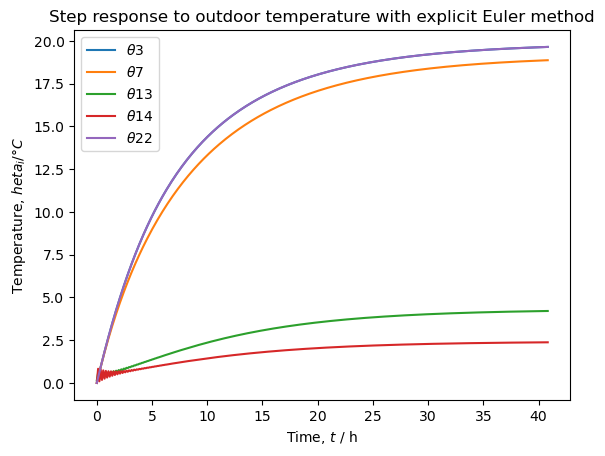

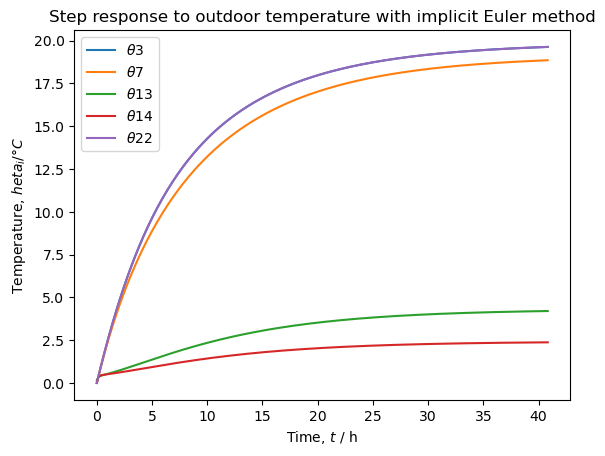

Steady state DAE model indoor temperatures: (19.868542602976106, 19.120356922003104, 4.303303053261081, 2.4247086716940736, 4.687072275339936)
Steady state state-space model indoor temperatures: (19.86854260297611, 19.12035692200312, 4.303303053261109, 2.4247086716940895, 4.687072275339944)
Steady state response to step input indoor temperatures: (19.64511234012268, 18.867602341641188, 4.205807870289772, 2.3751080053796656, 4.576809966036411)


In [33]:
number_of_state_variables = state_matrix.shape[0] # n_s
explicit_euler_state_variable_matrix = np.zeros([number_of_state_variables, time_steps.shape[0]]) # theta_exp
implicit_euler_state_variable_matrix = np.zeros([number_of_state_variables, time_steps.shape[0]]) # theta_imp

identity_matrix = np.eye(number_of_state_variables) # I

for k in range(number_of_time_steps - 1):
    explicit_euler_state_variable_matrix[:, k + 1] = ((identity_matrix + time_step * state_matrix) @ explicit_euler_state_variable_matrix[:, k]
                                                       + time_step * input_matrix @ input_vector[k, :])
    implicit_euler_state_variable_matrix[:, k + 1] = (np.linalg.inv(identity_matrix - time_step * state_matrix) @ (implicit_euler_state_variable_matrix[:, k]
                                                      + time_step * input_matrix @ input_vector[k, :]))

explicit_euler_output_matrix = output_matrix @ explicit_euler_state_variable_matrix + feedforward_matrix @ input_vector.T # y_exp 
implicit_euler_output_matrix = output_matrix @ implicit_euler_state_variable_matrix + feedforward_matrix @ input_vector.T # y_imp

mpl.figure()
mpl.plot(time_steps / 3600, explicit_euler_output_matrix.T[:, 0], label=r'$\theta 3$')
mpl.plot(time_steps / 3600, explicit_euler_output_matrix.T[:, 1], label=r'$\theta 7$')
mpl.plot(time_steps / 3600, explicit_euler_output_matrix.T[:, 2], label=r'$\theta 13$')
mpl.plot(time_steps / 3600, explicit_euler_output_matrix.T[:, 3], label=r'$\theta 14$')
mpl.plot(time_steps / 3600, explicit_euler_output_matrix.T[:, 0], label=r'$\theta 22$')
mpl.title('Step response to outdoor temperature with explicit Euler method')
mpl.xlabel('Time, $t$ / h')
mpl.ylabel('Temperature, ${\theta}_i / \degree C$')
mpl.legend()
mpl.show()

mpl.plot(time_steps / 3600, implicit_euler_output_matrix.T[:, 0], label=r'$\theta 3$')
mpl.plot(time_steps / 3600, implicit_euler_output_matrix.T[:, 1], label=r'$\theta 7$')
mpl.plot(time_steps / 3600, implicit_euler_output_matrix.T[:, 2], label=r'$\theta 13$')
mpl.plot(time_steps / 3600, implicit_euler_output_matrix.T[:, 3], label=r'$\theta 14$')
mpl.plot(time_steps / 3600, implicit_euler_output_matrix.T[:, 0], label=r'$\theta 22$')
mpl.title('Step response to outdoor temperature with implicit Euler method')
mpl.xlabel('Time, $t$ / h')
mpl.ylabel('Temperature, ${\theta}_i / \degree C$')
mpl.legend()
mpl.show()

print(f'Steady state DAE model indoor temperatures: {state_variable_vector[3], state_variable_vector[7], state_variable_vector[13], state_variable_vector[14], state_variable_vector[22]}')
print(f'Steady state state-space model indoor temperatures: {steady_state_output_vector[0], steady_state_output_vector[1], steady_state_output_vector[2], steady_state_output_vector[3], steady_state_output_vector[4]}')
print(f'Steady state response to step input indoor temperatures: {explicit_euler_output_matrix[0, -1], explicit_euler_output_matrix[1, -1], explicit_euler_output_matrix[2, -1], explicit_euler_output_matrix[3, -1], explicit_euler_output_matrix[4, -1]}') # TODO: Why did we work with -2? Are the results reasonable?

#### Simulation with weather data

##### Start and end time

In [34]:
simulation_start_date = '04-01 12:00:00' # 02-01
simulation_end_date = '04-07 18:00:00' # 02-07
simulation_start_date = '2004-' + simulation_start_date
simulation_end_date = '2004-' + simulation_end_date

print(f'Simulation start date: {simulation_start_date}')
print(f'Simulation end date: {simulation_end_date}')

Simulation start date: 2004-04-01 12:00:00
Simulation end date: 2004-04-07 18:00:00


##### Inputs

###### Read weather data

In [35]:
file_name = './weather_data/CHE_SG_St.Gallen.066810_TMYx.2004-2018.epw'
[data, meta] = dm4bem.read_epw(file_name, coerce_year=None)
weather_variables = data[['temp_air', 'dir_n_rad', 'dif_h_rad']]
del data

weather_variables.index = weather_variables.index.map(lambda t: t.replace(year=2004))
weather_variables = weather_variables.loc[simulation_start_date: simulation_end_date]

print(weather_variables)

                           temp_air  dir_n_rad  dif_h_rad
2004-04-01 12:00:00+01:00       9.7        776        173
2004-04-01 13:00:00+01:00      10.7        773        167
2004-04-01 14:00:00+01:00      11.1        773        132
2004-04-01 15:00:00+01:00      12.5        720        108
2004-04-01 16:00:00+01:00      13.3        454        139
...                             ...        ...        ...
2004-04-07 14:00:00+01:00       2.7         56        334
2004-04-07 15:00:00+01:00       1.1         16        206
2004-04-07 16:00:00+01:00       1.5          7        170
2004-04-07 17:00:00+01:00       2.6         52         98
2004-04-07 18:00:00+01:00       2.0          0         13

[151 rows x 3 columns]


###### Solar irradiance on the walls

In [36]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
tilted_surface_radiation = dm4bem.sol_rad_tilt_surf(weather_variables, surface_orientation, albedo)
tilted_surface_radiation['total_solar_irradiance'] = tilted_surface_radiation.sum(axis=1) # W/m^2, E_tot

print('Surface orientation:')
print(surface_orientation)
print()
print(f'Albedo: {albedo}')
print()
print('Tilted surface radiation:')
print()
print(tilted_surface_radiation)

Surface orientation:
{'slope': 90, 'azimuth': 0, 'latitude': 45}

Albedo: 0.2

Tilted surface radiation:

                                 direct  diffuse   reflected  \
2004-04-01 12:00:00+01:00  4.862161e+02     86.5  148.735125   
2004-04-01 13:00:00+01:00  4.298934e+02     83.5  136.205286   
2004-04-01 14:00:00+01:00  3.432872e+02     66.0  111.884034   
2004-04-01 15:00:00+01:00  2.146212e+02     54.0   80.197138   
2004-04-01 16:00:00+01:00  5.813475e+01     69.5   49.309583   
...                                 ...      ...         ...   
2004-04-07 14:00:00+01:00  2.314058e+01    167.0   73.293908   
2004-04-07 15:00:00+01:00  4.284762e+00    103.0   42.590036   
2004-04-07 16:00:00+01:00  6.891099e-01     85.0   34.371046   
2004-04-07 17:00:00+01:00  3.184082e-15     49.0   20.466260   
2004-04-07 18:00:00+01:00  0.000000e+00      6.5    2.600000   

                           total_solar_irradiance  
2004-04-01 12:00:00+01:00              721.451243  
2004-04-01 13:00:00+0

###### Resample the weather data


In [37]:
data = pd.concat([weather_variables['temp_air'], tilted_surface_radiation['total_solar_irradiance']], axis=1)
data = data.resample(str(time_step) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
data = data.rename_axis('Time')

print('Weather data:')
print()
print(data)
#print(data.iloc[0])
#print(data.iloc[0:17])
#data['To'].isna().sum()

data = data[data['To'].notna()]
print(data)

Weather data:

                            To  total_solar_irradiance
Time                                                  
2004-04-01 11:54:00+01:00  NaN                     NaN
2004-04-01 12:01:00+01:00  NaN                     NaN
2004-04-01 12:08:00+01:00  NaN                     NaN
2004-04-01 12:15:00+01:00  NaN                     NaN
2004-04-01 12:22:00+01:00  NaN                     NaN
...                        ...                     ...
2004-04-07 17:28:00+01:00  2.6                69.46626
2004-04-07 17:35:00+01:00  2.6                69.46626
2004-04-07 17:42:00+01:00  2.6                69.46626
2004-04-07 17:49:00+01:00  2.6                69.46626
2004-04-07 17:56:00+01:00  2.6                69.46626

[1287 rows x 2 columns]
                                  To  total_solar_irradiance
Time                                                        
2004-04-01 14:00:00+01:00  11.100000              521.171216
2004-04-01 14:07:00+01:00  11.071667              512.485029
2

###### Other inputs

In [38]:
data['adjacent_zone_temperature_setpoint'] = 22 * np.ones(data.shape[0]) # T_a-sp
data['indoor_temperature_setpoint'] = 0 * np.ones(data.shape[0]) # T_i-sp
data['auxiliary_heat_flow_rate'] = 0 * np.ones(data.shape[0]) #Q_a 

print('Weather data:')
print()
print(data)

Weather data:

                                  To  total_solar_irradiance  \
Time                                                           
2004-04-01 14:00:00+01:00  11.100000              521.171216   
2004-04-01 14:07:00+01:00  11.071667              512.485029   
2004-04-01 14:14:00+01:00  11.043333              503.798842   
2004-04-01 14:21:00+01:00  11.015000              495.112655   
2004-04-01 14:28:00+01:00  10.986667              486.426468   
...                              ...                     ...   
2004-04-07 17:28:00+01:00   2.600000               69.466260   
2004-04-07 17:35:00+01:00   2.600000               69.466260   
2004-04-07 17:42:00+01:00   2.600000               69.466260   
2004-04-07 17:49:00+01:00   2.600000               69.466260   
2004-04-07 17:56:00+01:00   2.600000               69.466260   

                           adjacent_zone_temperature_setpoint  \
Time                                                            
2004-04-01 14:00:00+01

###### Input vector in time

In [39]:
print(data)

                                  To  total_solar_irradiance  \
Time                                                           
2004-04-01 14:00:00+01:00  11.100000              521.171216   
2004-04-01 14:07:00+01:00  11.071667              512.485029   
2004-04-01 14:14:00+01:00  11.043333              503.798842   
2004-04-01 14:21:00+01:00  11.015000              495.112655   
2004-04-01 14:28:00+01:00  10.986667              486.426468   
...                              ...                     ...   
2004-04-07 17:28:00+01:00   2.600000               69.466260   
2004-04-07 17:35:00+01:00   2.600000               69.466260   
2004-04-07 17:42:00+01:00   2.600000               69.466260   
2004-04-07 17:49:00+01:00   2.600000               69.466260   
2004-04-07 17:56:00+01:00   2.600000               69.466260   

                           adjacent_zone_temperature_setpoint  \
Time                                                            
2004-04-01 14:00:00+01:00            

In [40]:
outdoor_temperature_time_series_vector = data['To'] # T_o
adjacent_zone_temperature_setpoint_time_series_vector = data['adjacent_zone_temperature_setpoint'] # T_a-sp
indoor_temperature_setpoint_time_series_vector = data['indoor_temperature_setpoint'] # T_i-sp
outdoor_wall_surface_short_wave_radiation_time_series_vector = (short_wave_white_smooth_surface_absortivity * wall_properties['Surface']['Outside_layer'] # phi_o 
                                                     * data['total_solar_irradiance'])
indoor_wall_surface_short_wave_radiation_time_series_vector = (short_wave_reflective_blue_window_transmittance * short_wave_white_smooth_surface_absortivity # phi_i
                                                               * wall_properties['Surface']['Window'] * data['total_solar_irradiance'])
auxiliary_heat_flow_rate_time_series_vector = data['auxiliary_heat_flow_rate'] # Q_a
window_short_wave_radiation_time_series_vector = (short_wave_reflective_blue_window_absortivity * wall_properties['Surface']['Window'] # phi_a
                                                  * data['total_solar_irradiance'])

input_in_time_vector = pd.concat([adjacent_zone_temperature_setpoint_time_series_vector, indoor_temperature_setpoint_time_series_vector, # u
                                  adjacent_zone_temperature_setpoint_time_series_vector, indoor_temperature_setpoint_time_series_vector,
                                  indoor_temperature_setpoint_time_series_vector, indoor_temperature_setpoint_time_series_vector,
                                  outdoor_temperature_time_series_vector, outdoor_temperature_time_series_vector,
                                  indoor_temperature_setpoint_time_series_vector, outdoor_temperature_time_series_vector,
                                  outdoor_wall_surface_short_wave_radiation_time_series_vector, outdoor_wall_surface_short_wave_radiation_time_series_vector,
                                  indoor_wall_surface_short_wave_radiation_time_series_vector, indoor_wall_surface_short_wave_radiation_time_series_vector,
                                  window_short_wave_radiation_time_series_vector], axis=1)

print('Outdoor temperature time series vector:')
print()
print(outdoor_temperature_time_series_vector)
print()
print('Adjacent zone temperature setpoint time series vector:')
print()
print(adjacent_zone_temperature_setpoint_time_series_vector)
print()
print('Indoor temperature setpoint time series vector:')
print()
print(indoor_temperature_setpoint_time_series_vector)
print()
print('Outdoor wall surface short wave radiation time series vector:')
print()
print(outdoor_wall_surface_short_wave_radiation_time_series_vector)
print()
print('Indoor wall surface short wave radiation time series vector:')
print()
print(indoor_wall_surface_short_wave_radiation_time_series_vector)
print()
print('Auxiliary heat flow rate time series vector:')
print()
print(auxiliary_heat_flow_rate_time_series_vector)
print()
print('Window short wave radiation time series vector:')
print()
print(window_short_wave_radiation_time_series_vector)
print()
print('Input in time vector:')
print(input_in_time_vector)

Outdoor temperature time series vector:

Time
2004-04-01 14:00:00+01:00    11.100000
2004-04-01 14:07:00+01:00    11.071667
2004-04-01 14:14:00+01:00    11.043333
2004-04-01 14:21:00+01:00    11.015000
2004-04-01 14:28:00+01:00    10.986667
                               ...    
2004-04-07 17:28:00+01:00     2.600000
2004-04-07 17:35:00+01:00     2.600000
2004-04-07 17:42:00+01:00     2.600000
2004-04-07 17:49:00+01:00     2.600000
2004-04-07 17:56:00+01:00     2.600000
Freq: 420S, Name: To, Length: 1269, dtype: float64

Adjacent zone temperature setpoint time series vector:

Time
2004-04-01 14:00:00+01:00    22.0
2004-04-01 14:07:00+01:00    22.0
2004-04-01 14:14:00+01:00    22.0
2004-04-01 14:21:00+01:00    22.0
2004-04-01 14:28:00+01:00    22.0
                             ... 
2004-04-07 17:28:00+01:00    22.0
2004-04-07 17:35:00+01:00    22.0
2004-04-07 17:42:00+01:00    22.0
2004-04-07 17:49:00+01:00    22.0
2004-04-07 17:56:00+01:00    22.0
Freq: 420S, Name: adjacent_zone_temper

In [41]:
print('Outdoor temperature time series vector:')
print()
print(outdoor_temperature_time_series_vector.shape)
print()
print('Adjacent zone temperature setpoint time series vector:')
print()
print(adjacent_zone_temperature_setpoint_time_series_vector.shape)
print()
print('Indoor temperature setpoint time series vector:')
print()
print(indoor_temperature_setpoint_time_series_vector.shape)
print()
print('Outdoor wall surface short wave radiation time series vector:')
print()
print(outdoor_wall_surface_short_wave_radiation_time_series_vector.shape)
print()
print('Indoor wall surface short wave radiation time series vector:')
print()
print(indoor_wall_surface_short_wave_radiation_time_series_vector.shape)
print()
print('Auxiliary heat flow rate time series vector:')
print()
print(auxiliary_heat_flow_rate_time_series_vector.shape)
print()
print('Window short wave radiation time series vector:')
print()
print(window_short_wave_radiation_time_series_vector.shape)
print()
print('Input in time vector:')
print(input_in_time_vector.shape)

Outdoor temperature time series vector:

(1269,)

Adjacent zone temperature setpoint time series vector:

(1269,)

Indoor temperature setpoint time series vector:

(1269,)

Outdoor wall surface short wave radiation time series vector:

(1269,)

Indoor wall surface short wave radiation time series vector:

(1269,)

Auxiliary heat flow rate time series vector:

(1269,)

Window short wave radiation time series vector:

(1269,)

Input in time vector:
(1269, 15)


##### Initial conditions

In [42]:
number_of_state_variables = state_matrix.shape[0] # n_s
explicit_euler_state_variable_matrix = 20 * np.ones([number_of_state_variables, input_in_time_vector.shape[0]]) # theta_exp
print('Explicit Euler state variable matrix:')
print()
print(explicit_euler_state_variable_matrix)

Explicit Euler state variable matrix:

[[20. 20. 20. ... 20. 20. 20.]
 [20. 20. 20. ... 20. 20. 20.]
 [20. 20. 20. ... 20. 20. 20.]
 [20. 20. 20. ... 20. 20. 20.]]


##### Time integration

In [43]:
print(identity_matrix.shape)
print(time_step.shape)
print(state_matrix.shape)
print(input_matrix.shape)
print(input_in_time_vector.shape)
print()
print(input_in_time_vector)

(4, 4)
()
(4, 4)
(4, 15)
(1269, 15)

                           adjacent_zone_temperature_setpoint  \
Time                                                            
2004-04-01 14:00:00+01:00                                22.0   
2004-04-01 14:07:00+01:00                                22.0   
2004-04-01 14:14:00+01:00                                22.0   
2004-04-01 14:21:00+01:00                                22.0   
2004-04-01 14:28:00+01:00                                22.0   
...                                                       ...   
2004-04-07 17:28:00+01:00                                22.0   
2004-04-07 17:35:00+01:00                                22.0   
2004-04-07 17:42:00+01:00                                22.0   
2004-04-07 17:49:00+01:00                                22.0   
2004-04-07 17:56:00+01:00                                22.0   

                           indoor_temperature_setpoint  \
Time                                                     
2

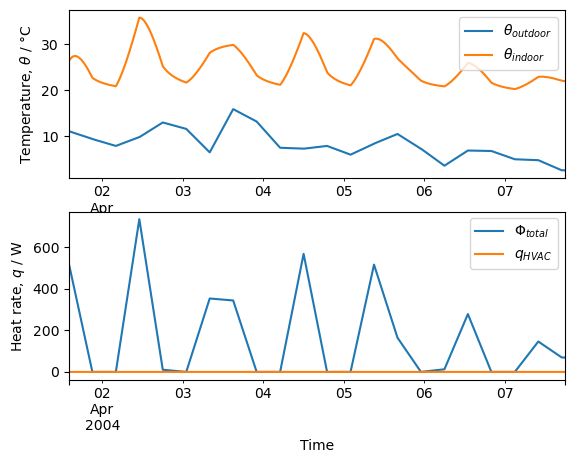

In [44]:
for k in range(input_in_time_vector.shape[0] - 1):
    explicit_euler_state_variable_matrix[:, k + 1] = ((identity_matrix + time_step * state_matrix) @ explicit_euler_state_variable_matrix[:, k] # theta_s-k+1
                                                       + time_step * input_matrix @ input_in_time_vector.iloc[k, :])

explicit_euler_output_matrix = output_matrix @ explicit_euler_state_variable_matrix + feedforward_matrix @ input_in_time_vector.to_numpy().T # y_exp
hvac_system_heat_flow_rate_output_matrix = proportional_gain * (data['indoor_temperature_setpoint'] - explicit_euler_output_matrix[0, :]) # q_hvac

data['explicit_euler_output_0_matrix'] = explicit_euler_output_matrix[0].T # thetai_exp
data['explicit_euler_output_1_matrix'] = explicit_euler_output_matrix[1].T
data['explicit_euler_output_2_matrix'] = explicit_euler_output_matrix[2].T
data['hvac_system_heat_flow_rate_output'] = hvac_system_heat_flow_rate_output_matrix.T # q_hvac

fig, axs = mpl.subplots(2, 1)

data[['To', 'explicit_euler_output_0_matrix']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['total_solar_irradiance', 'hvac_system_heat_flow_rate_output']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
mpl.show()

In [45]:
print(data['explicit_euler_output_0_matrix'])
print(data['explicit_euler_output_1_matrix'])
print(data['explicit_euler_output_2_matrix'])

Time
2004-04-01 14:00:00+01:00    26.293528
2004-04-01 14:07:00+01:00    26.454542
2004-04-01 14:14:00+01:00    26.600949
2004-04-01 14:21:00+01:00    26.733464
2004-04-01 14:28:00+01:00    26.852757
                               ...    
2004-04-07 17:28:00+01:00    22.021897
2004-04-07 17:35:00+01:00    22.012065
2004-04-07 17:42:00+01:00    22.002521
2004-04-07 17:49:00+01:00    21.993250
2004-04-07 17:56:00+01:00    21.984238
Freq: 420S, Name: explicit_euler_output_0_matrix, Length: 1269, dtype: float64
Time
2004-04-01 14:00:00+01:00    19.598552
2004-04-01 14:07:00+01:00    19.625675
2004-04-01 14:14:00+01:00    19.657404
2004-04-01 14:21:00+01:00    19.693094
2004-04-01 14:28:00+01:00    19.732230
                               ...    
2004-04-07 17:28:00+01:00    19.436530
2004-04-07 17:35:00+01:00    19.432135
2004-04-07 17:42:00+01:00    19.427621
2004-04-07 17:49:00+01:00    19.423004
2004-04-07 17:56:00+01:00    19.418296
Freq: 420S, Name: explicit_euler_output_1_matrix, Len

In [46]:
print(explicit_euler_output_matrix)

[[26.29352824 26.45454184 26.60094887 ... 22.00252102 21.99324992
  21.98423789]
 [19.59855198 19.62567467 19.65740363 ... 19.42762129 19.42300378
  19.41829632]
 [ 8.20456222  4.01858265  7.74744113 ...  3.68363817  3.68120326
   3.67967953]
 [ 7.2611465  -0.74842066  6.46901247 ...  1.89466285  1.89276449
   1.89258472]
 [ 6.92166998  6.67745976  6.83197865 ...  4.15027608  4.14802598
   4.14584805]]
